# **1. Forecasting urban floods**

*pitched by Samuel Barsanelli Costa | ```Data Science batch #1643```*

## **1.1. Problem statement**

What is an urban flood and why should we care about forecasting it?

📽️ A picture is worth a thousand words...

<iframe width="600" height="339"
src="https://www.youtube.com/embed/qefFjVbrZwE?autoplay=1&mute=1">
</iframe>

This is a global issue related to climate change, as raised by the [UN](https://www.undrr.org/)'s [GAR23](https://www.undrr.org/gar/gar2023-special-report) report:
* the increase in the intensity of rainfall is already increasing flood risk 🌧️
* flood damage shall increase by **170%** with a global **2°C warming** 🔥

Additional regional conditions may intensify this effects, such as the El Niño that triggered [unprecedented flooding in the southern Brazilian state of Rio Grande do Sul](https://wmo.int/media/news/el-nino-linked-rains-trigger-devastation-brazil).

🌎 With the best **think globally, act locally** spirit in mind, this idea is scoped to predict flood in São Leopoldo/RS, Brazil, one among the most affected cities in the Porto Alegre Metro Area during the flooding events of May 2024.

🌶 From a data science perpective, flood prediction is a hot topic. The [Journal of Hydrology](https://www.sciencedirect.com/journal/journal-of-hydrology) alone has over 5k papers about it. Even Google has it's own AI model to predict flood. They've published their approach in a must-read [paper](https://www.nature.com/articles/s41586-024-07145-1) in Nature, and made their findings available at [Flood Hub](https://sites.research.google/floods/l/0/0/3) for 80+ countries.

🧠 The vast majority of the research applies **RNN-LSTM** models for flood predictions.

![https://sites.research.google/floods/](google_flood_hub.jpg)

But all resources available about flooding are way too much technical, not suited for the general public.

🤔 Could you quickly disgest this [data plot](https://app.powerbi.com/view?r=eyJrIjoiZTRjZDlmYjgtNzAzMS00ZTFmLTlmZDAtNzEwNjM0MDU0NTJhIiwidCI6ImUwYmI0MDEyLTgxMGItNDY5YS04YjRkLTY2N2ZjZDFiYWY4OCJ9) and make an informed "fight-or-flight" decision if you should stay or run away from this flood risk area?

![https://app.powerbi.com/view?r=eyJrIjoiZTRjZDlmYjgtNzAzMS00ZTFmLTlmZDAtNzEwNjM0MDU0NTJhIiwidCI6ImUwYmI0MDEyLTgxMGItNDY5YS04YjRkLTY2N2ZjZDFiYWY4OCJ9](guaiba_telemetry.jpg)

🤓 What if we train a model and make it a **near real-time forescat web-app**, with very easy-to-digest info just like weather forecasts?

💪 Let's code this together!


<html>
<head>
<style>
img {
  width: 100%;
}
</style>
</head>
<body>

<img src="flood_forecast_app.jpg" alt="What if the flood forecast was like this?" style="width:700px;">

</body>
</html>

## **1.2. Data sources**

 To address this problem we'll need, at least:

* **river stage data**: the measure of the water level of a river (usually measured in cm). This will be our ```y```
* **historical rainfall data**: the amount of rainfall at a certain location (usually measured in mm). This will be our ```X```.
* **future rainfall data**: rain forecast. This will be our ```X``` to get the ```y_pred```.
* **meteorological data**: additional meaninfull ```X```s such as air temperature, surface pressure, soil moisture at different depths, wind speed and solar radiance.

Automated Telemetry Stations comes out to be the best source for ground-truth river and rain data, as they continuosly collect data at a certain timeframe (usually every 15 min). Additional meteorological data might be derived from global weather forecast models.

❗**Relevant info regarding rain data sourcing**❗

* Rain data is the most relevant exougenous variable for flood prediction.
* But rainfall is not well represented by a single point-source.
* See the picture bellow: all rain from up in the mountains will, at some point in time, flow downhill and hit the lowest point, hence contributing to a flood.
* So the more rainfall stations we collect data from within the contributing are, the best!

<html>
<head>
<style>
img {
  width: 100%;
}
</style>
</head>
<body>

<img src="https://elbowlakecentre.ca/wp-content/uploads/2023/11/Picture1-4.png.webp" alt="https://elbowlakecentre.ca/wp-content/uploads/2023/11/Picture1-4.png.webp" style="width:400px;">

</body>
</html>

In order to predict flood at São Leopoldo/RS, Brazil (the ❗ on the map), besides the river stage data (```y```) and rain data (```X```) from the very location of the flood, we'll take advantage of other six rain stations distributed over it's drainage area (the 🌧 on the map).


<html>
<head>
<style>
img {
  width: 100%;
}
</style>
</head>
<body>

<img src="data_sources.jpg" style="width:600px;">

</body>
</html>

Here are the data sources details to be downloaded.

| Data | Source | Format | Sampling rate | Time span | Raw data files |
|------|--------|--------|---------------|-----------|----------------|
| River stage | [SEMA/RS](https://saladesituacao.rs.gov.br/dados) | xls | 15 min  | 2018 on |[river_rain_data.zip](https://drive.google.com/file/d/1lOX845O653rK7Onz0AWZzmelre_IaNRi/view?usp=sharing) |
| Rainfall | [SEMA/RS](https://saladesituacao.rs.gov.br/dados) | xls | 15 min | 2018 on |  👆 *same as above* |
| Rain forescast and meteo data | [Open-Meteo](https://open-meteo.com/en/docs) | API | 1 hour | 1940 up to next 5 days | [historical_meteo_data.zip](https://drive.google.com/file/d/1YArQyT5vuFqmv5xQpckYz8Cxc5-UFaOg/view?usp=sharing) |

In [2]:
import pandas as pd
import warnings; warnings.filterwarnings('ignore')
import requests
import io

# Get streamgage data from Sao Leopoldo station
response = requests.get('https://saladesituacao.rs.gov.br/api/station/ana/sheet/87382000')

# Convert the binary response to an excel file and pass it to a dataframe
with io.BytesIO(response.content) as excel_file:
    df = pd.io.excel.read_excel(
        excel_file,
        skiprows = 8,
        names = ['date', 'stage', 'discharge', 'rainfall'],
        dtype = {'date': object, 'stage': float, 'discharge': float, 'rainfall': float}
    )

# Drop discharge column
df = df.drop(columns='discharge')

# Parse date and set it as index
df.index = pd.to_datetime(df.date, format='%d/%m/%Y %H:%M:%S', )
df.index.name = None
df.sort_index(ascending=True, inplace=True)
df.drop(columns='date', inplace=True)

# Source preview
df

,stage,rainfall
2018-08-01 13:15:00,358.0,NaN
2018-08-01 13:30:00,358.0,0.0
2018-08-01 13:45:00,357.0,0.0
2018-08-01 14:00:00,357.0,0.0
2018-08-01 14:15:00,357.0,0.0
...,...,...
2024-07-24 19:15:00,267.0,0.0
2024-07-24 19:30:00,267.0,0.0
2024-07-24 19:45:00,266.0,0.0
2024-07-24 20:00:00,266.0,0.0


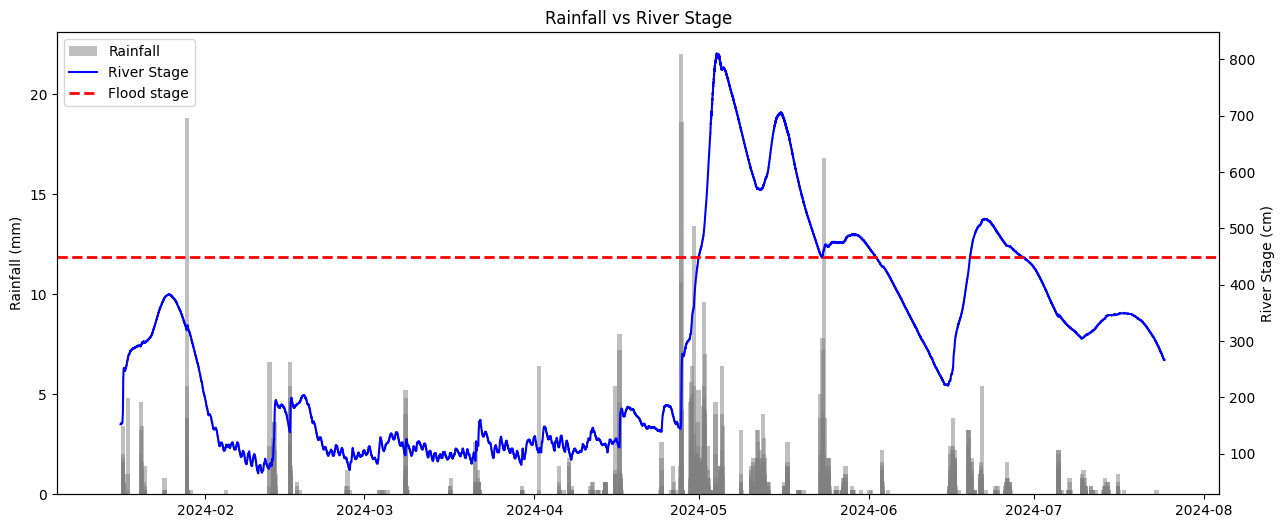

In [3]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

# Slice and sort the dataframe for the plot
start_date = '2024-01-15'
# end_date = '2024-07-15'
df_slice = df.loc[start_date:]

# Create the plot
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot rainfall on the primary y-axis
ax1.bar(df_slice.index, df_slice.rainfall, color='gray', alpha=0.5, label='Rainfall')
ax1.set_ylabel('Rainfall (mm)')
ax1.tick_params(axis='y')

# Create a secondary y-axis for stage
ax2 = ax1.twinx()
ax2.plot(df_slice.index, df_slice.stage, color='blue', label='River Stage')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('River Stage (cm)')
ax2.tick_params(axis='y')

# Add reference lines (uncomment if needed)
ax2.axhline(y=450, color='red', linestyle='--', linewidth=2, label='Flood stage')
# plt.axvline(dt.datetime(2024, 4, 27, hour=12), color='black', linestyle='--', label='Stage rise')
# plt.axvline(dt.datetime(2024, 5, 4, hour=12), color='black', linestyle='-.', label='Stage peak')

# Add legends
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
ax1.legend(lines + bars, labels + bar_labels, loc='upper left')

# Show the plot
plt.title('Rainfall vs River Stage')
plt.show()

📈 And here's a quick plot of a small subset of the river stage and rainfall data from the rmost ecent flood event at São Leopoldo/RS, Brazil:
* Over **6 months** of 15-min ininterrupt data collection, from January 15th 2024 up to now.
* Accumulated rainfall over a moving window of 11 days (the time it takes for the most distant raindrop to get down to the flooding area).
* One historical flooding event registered (May 4th 2024)
* Over **17k data samples**

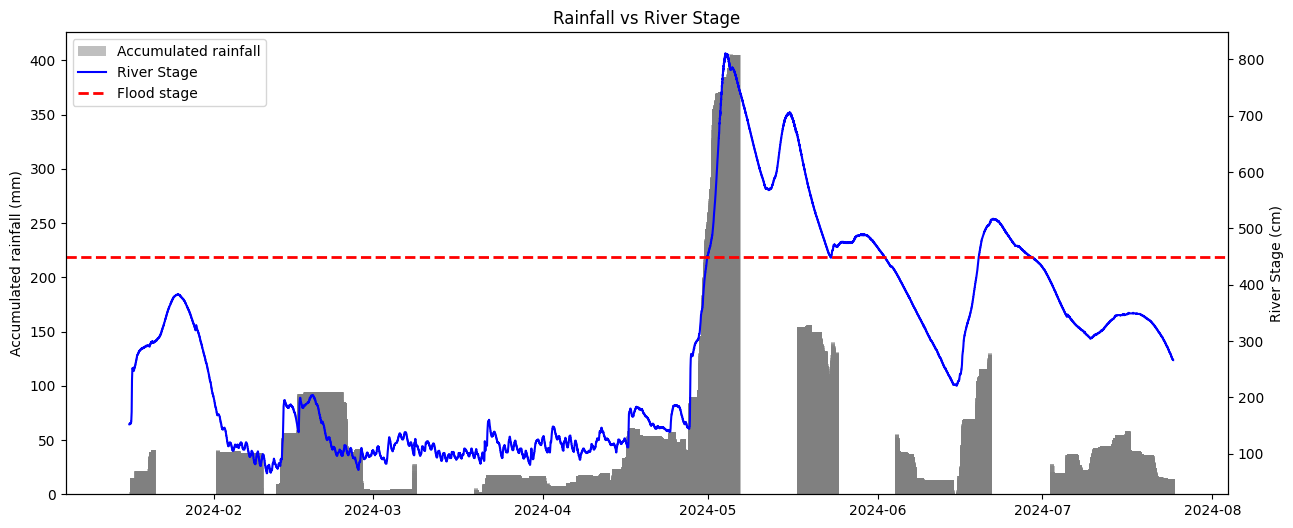

In [4]:
# Accumulated rainfall
## Get the amount of samples to be accumulated
peak_time = dt.datetime(2024, 5, 4, hour=12) - dt.datetime(2024, 4, 27, hour=12)
concentration_time = (peak_time / 0.6).days
concentration_time_samples = concentration_time * 24 * 4    # one sample every 15 min

## Add it to a new column in the df
temp = np.convolve(df_slice.rainfall, np.ones(concentration_time_samples))
df_slice['accum_rainfall'] = temp[:df_slice.shape[0]]

# Create a new plot
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot rainfall on the primary y-axis
ax1.bar(df_slice.index, df_slice.accum_rainfall, color='gray', alpha=0.5, label='Accumulated rainfall')
ax1.set_ylabel('Accumulated rainfall (mm)')
ax1.tick_params(axis='y')

# Create a secondary y-axis for stage
ax2 = ax1.twinx()
ax2.plot(df_slice.index, df_slice.stage, color='blue', label='River Stage')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('River Stage (cm)')
ax2.tick_params(axis='y')

# Add reference lines
ax2.axhline(y=450, color='red', linestyle='--', linewidth=2, label='Flood stage')

# Add legends
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
ax1.legend(lines + bars, labels + bar_labels, loc='upper left')

# Show the plot
plt.title('Rainfall vs River Stage')
plt.show()

👇 Finally, a fresh hourly weather forecast for São Leopoldo, taken from the Open-Meteo API pointing out to the [Global Forecast System (GFS)](https://www.ncei.noaa.gov/products/weather-climate-models/global-forecast) model.

❗A limitation to keep in mind is that the API's non-commercial free tier allows 10,000 calls/day.

In [9]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": -29.761076,
	"longitude": -51.148365,
	"hourly": ["temperature_2m", "precipitation_probability", "rain"],
    "models": "gfs_seamless"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
# print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
# print(f"Elevation {response.Elevation()} m asl")
# print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
# print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation_probability = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature"] = hourly_temperature_2m
hourly_data["rainfall_proba"] = hourly_precipitation_probability
hourly_data["rainfall"] = hourly_rain

forecast_df = pd.DataFrame(data = hourly_data)
forecast_df.index = forecast_df['date']
forecast_df.index.name = None
forecast_df.sort_index(ascending=True, inplace=True)
forecast_df.drop(columns='date', inplace=True)
forecast_df

,temperature,rainfall_proba,rainfall
2024-07-24 00:00:00+00:00,18.636000,0.0,0.0
2024-07-24 01:00:00+00:00,18.335999,0.0,0.0
2024-07-24 02:00:00+00:00,18.035999,0.0,0.0
2024-07-24 03:00:00+00:00,18.335999,0.0,0.0
2024-07-24 04:00:00+00:00,17.736000,0.0,0.0
...,...,...,...
2024-07-30 19:00:00+00:00,16.435999,10.0,0.0
2024-07-30 20:00:00+00:00,14.736000,11.0,0.0
2024-07-30 21:00:00+00:00,13.236000,10.0,0.0
2024-07-30 22:00:00+00:00,12.286000,7.0,0.0


### 1.2.1. Meteorological data

In [5]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": -29.7589,
	"longitude": -51.1483,
	"start_date": "2018-01-01",
	"end_date": "2024-07-20",
	"hourly": ["temperature_2m", "surface_pressure", "wind_speed_100m", "soil_moisture_0_to_7cm", "soil_moisture_7_to_28cm", "soil_moisture_28_to_100cm", "soil_moisture_100_to_255cm", "direct_radiation"],
	"timezone": "America/Sao_Paulo"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(1).ValuesAsNumpy()
hourly_wind_speed_100m = hourly.Variables(2).ValuesAsNumpy()
hourly_soil_moisture_0_to_7cm = hourly.Variables(3).ValuesAsNumpy()
hourly_soil_moisture_7_to_28cm = hourly.Variables(4).ValuesAsNumpy()
hourly_soil_moisture_28_to_100cm = hourly.Variables(5).ValuesAsNumpy()
hourly_soil_moisture_100_to_255cm = hourly.Variables(6).ValuesAsNumpy()
hourly_direct_radiation = hourly.Variables(7).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm
hourly_data["soil_moisture_7_to_28cm"] = hourly_soil_moisture_7_to_28cm
hourly_data["soil_moisture_28_to_100cm"] = hourly_soil_moisture_28_to_100cm
hourly_data["soil_moisture_100_to_255cm"] = hourly_soil_moisture_100_to_255cm
hourly_data["direct_radiation"] = hourly_direct_radiation

meteo_df = pd.DataFrame(data = hourly_data)
meteo_df.index = meteo_df['date']
meteo_df.index.name = None
meteo_df.sort_index(ascending=True, inplace=True)
meteo_df.drop(columns='date', inplace=True)

meteo_df.to_csv('historical_meteo_data.csv')

meteo_df

Coordinates -29.771530151367188°N -51.114990234375°E
Elevation 6.0 m asl
Timezone b'America/Sao_Paulo' b'-03'
Timezone difference to GMT+0 -10800 s


,temperature_2m,surface_pressure,wind_speed_100m,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,direct_radiation
2018-01-01 03:00:00+00:00,21.527500,1006.299927,17.057314,0.399,0.406,0.389,0.460,0.0
2018-01-01 04:00:00+00:00,21.027500,1006.098694,13.138765,0.399,0.406,0.389,0.460,0.0
2018-01-01 05:00:00+00:00,20.277500,1005.697144,9.021574,0.399,0.406,0.389,0.460,0.0
2018-01-01 06:00:00+00:00,20.227501,1004.997620,9.449572,0.399,0.406,0.389,0.460,0.0
2018-01-01 07:00:00+00:00,19.927502,1004.597229,7.491114,0.399,0.406,0.389,0.460,0.0
...,...,...,...,...,...,...,...,...
2024-07-20 22:00:00+00:00,16.127501,1022.475159,17.533146,0.470,0.481,0.482,0.503,0.0
2024-07-20 23:00:00+00:00,15.077500,1022.272705,16.071491,0.470,0.481,0.482,0.503,0.0
2024-07-21 00:00:00+00:00,14.227500,1021.870789,14.764389,0.470,0.480,0.482,0.503,0.0
2024-07-21 01:00:00+00:00,13.077500,1021.967834,13.397612,0.467,0.479,0.481,0.503,0.0


# 💪 Let's code this together!

# **2. Slides and HTML Export**

From here on the cells are ommited from the html-slide

In [19]:
# Run this cell to save the notebook before generating slides
from IPython.display import Javascript, display
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [11]:
# Run this cell to generate slides and hit stop to kill the server
!jupyter nbconvert idea-viability.ipynb --to slides --post serve --no-prompt \
--TagRemovePreprocessor.remove_input_tags=remove_input \
--TagRemovePreprocessor.remove_all_outputs_tags=remove_output

[NbConvertApp] Converting notebook idea-viability.ipynb to slides
[NbConvertApp] Writing 682792 bytes to idea-viability.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/idea-viability.slides.html
Use Control-C to stop this server
404 GET /favicon.ico (127.0.0.1) 0.97ms
^C

Interrupted


In [13]:
# Run this cell to rename the *.slides.hmtl and push it to the host
import os
os.rename('idea-viability.slides.html', 'index.html')

!git add index.html
!git commit -m 'updated index.html'
!git push origin main

FileNotFoundError: [Errno 2] No such file or directory: 'idea-viability.slides.html' -> 'index.html'

Wait a few minutes after the push to broadcast the updates in the repo and hit the link!

👉 [Link to the published html-slide](https://samuelbarsanellicosta.github.io/data-flood-forecasting-pitch/)

<details>
    <summary><i>💡 Details about generating a html-slide version of the notebook</i></summary>

In VSCode, right-click on the cell and:
- Click on `Switch Slide Type` to set the proper configuration for the cell
- Click on `Add Cell Tag` to add tags if needed

Then, generate an html-slide version of this using the following command:

```
jupyter nbconvert index.ipynb --to slides --post serve --no-prompt \
--TagRemovePreprocessor.remove_input_tags=remove_input \
--TagRemovePreprocessor.remove_all_outputs_tags=remove_output
```

- `no-prompt` removes the In [xx]: and Out[xx]: to the left of each cells
- `--TagRemovePreprocessor` allows you to not display either inputs or outputs of cells that have the associated Tag

As for hosting the html using GitHub, pages change the ```<output-format>``` like this:

``` jupyter nbconvert --to html index.ipynb ```

Make sure to name the notebook as 'index' and that GitHub Pages [settings](https://pages.github.com/) are properly set.

</details>